# LG3 Feature Drop Analysis Demo

이 노트북은 `forecast_metrics.csv`를 기준으로 성능이 낮은 컬럼을 찾고,
제거 후보를 빠르게 확인할 수 있도록 돕습니다.

- feature별 MSE/MAE 요약 확인
- 상위/하위 성능 컬럼 비교
- 단순 기준(threshold/percentile)으로 drop 후보 추출


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

METRICS_CSV = "../results/forecast_metrics.csv"

# 기준 설정
SCORE_COL = "mae"  # or "mse"
PERCENTILE = 90   # 상위 90% (값이 클수록 나쁨)
TOP_K = 5


In [ ]:
df = pd.read_csv(METRICS_CSV)
df = df[df["feature"] != "__all__"]
df = df.sort_values(SCORE_COL, ascending=False)

display(df.head(10))
display(df.tail(10))


,feature,mse,mae
1,MFR_068,11217.262045,43.561758
10,SCEEV_M,829.108988,6.672403
9,Tcond,86.558859,5.000124
4,Comp1 Hz_0,77.919979,3.745580
3,Comp1 Hz_1,72.551644,3.326240
11,Tod,7.133902,2.152586
6,VAP_Entha,103.160014,1.790580
7,LIQ_Entha,21.942847,0.828089
5,Power,3.672678,0.754782
15,week_cos,0.186436,0.341517


,feature,mse,mae
6,VAP_Entha,103.160014,1.790580
7,LIQ_Entha,21.942847,0.828089
5,Power,3.672678,0.754782
15,week_cos,0.186436,0.341517
14,week_sin,0.183085,0.335679
13,day_cos,0.071685,0.224563
12,day_sin,0.071716,0.224479
8,cycle,0.203735,0.195159
0,Capa_Cooling,0.029339,0.041115
2,Rop,0.003630,0.027326


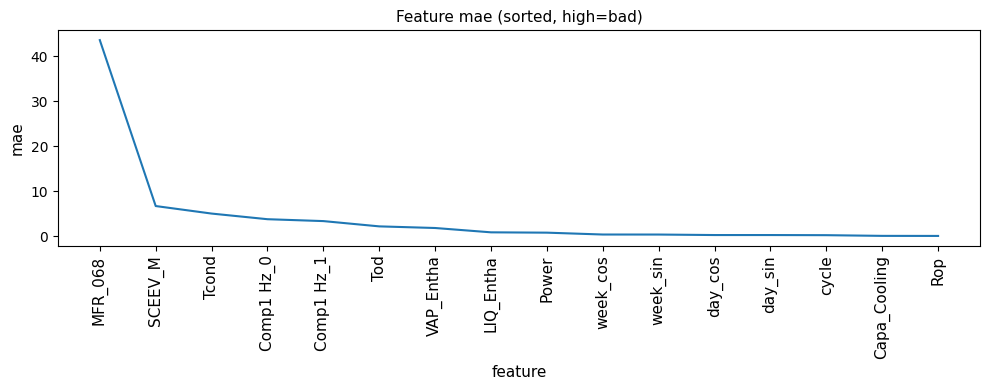

In [ ]:
FONT_SIZE = 11
plt.figure(figsize=(10, 4))
plt.plot(df[SCORE_COL].values)
plt.title(f"Feature {SCORE_COL} (sorted, high=bad)", fontsize=FONT_SIZE)
plt.xlabel("feature", fontsize=FONT_SIZE)
plt.ylabel(SCORE_COL, fontsize=FONT_SIZE)
plt.xticks(ticks=range(len(df)), labels=df["feature"], rotation=90, fontsize=FONT_SIZE)
plt.tight_layout()
plt.show()


In [ ]:
threshold = np.percentile(df[SCORE_COL], PERCENTILE)
candidates = df[df[SCORE_COL] >= threshold]
print(f"Drop candidates (>= {PERCENTILE}th percentile):")
display(candidates)

print(f"Worst {TOP_K} features by {SCORE_COL}:")
display(df.head(TOP_K))


Drop candidates (>= 90th percentile):


,feature,mse,mae
1,MFR_068,11217.262045,43.561758
10,SCEEV_M,829.108988,6.672403


Worst 5 features by mae:


,feature,mse,mae
1,MFR_068,11217.262045,43.561758
10,SCEEV_M,829.108988,6.672403
9,Tcond,86.558859,5.000124
4,Comp1 Hz_0,77.919979,3.745580
3,Comp1 Hz_1,72.551644,3.326240


## 판단 기준 예시

- `mae` 또는 `mse` 상위 10~20% 컬럼은 drop 후보
- 모델 성능에 중요한지 확인하려면 해당 컬럼을 제외해 재학습 비교
- 타겟과의 상관, 도메인 중요도도 함께 고려


## 특정 컬럼 시각화

- 아래 `FEATURE_NAME`을 원하는 컬럼으로 바꿔서 재실행하면 됩니다.
- 실행할 때마다 랜덤 구간을 보여줍니다.


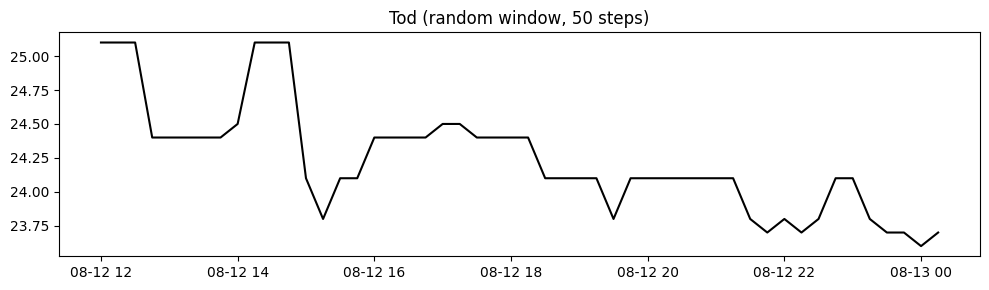

In [ ]:
import random

PROCESSED_CSV = "../data/processed/lg3_train.csv"
FEATURE_NAME = "Tod"
WINDOW_LEN = 50

df = pd.read_csv(PROCESSED_CSV, index_col=0, parse_dates=True)
if FEATURE_NAME not in df.columns:
    raise ValueError(f"Feature '{FEATURE_NAME}' not in {PROCESSED_CSV}")

series = df[FEATURE_NAME].dropna()
if len(series) <= WINDOW_LEN:
    seg = series
else:
    start = random.randint(0, len(series) - WINDOW_LEN)
    seg = series.iloc[start : start + WINDOW_LEN]

plt.figure(figsize=(10, 3))
plt.plot(seg.index, seg.values, color="black")
plt.title(f"{FEATURE_NAME} (random window, {len(seg)} steps)")
plt.tight_layout()
plt.show()
